In [1]:
%matplotlib inline

#
# import utilitaires
#
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

import helpers as hlp
import helpers.split as split
import helpers.visual_words as vw
import helpers.features as feat

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
#
# parametres
#
configs = hlp.get_configs("config_overrides.json")

#
# train/test sets
# 
train, test = split.load(configs.split)
print("Train size", len(train))
print("Test size", len(test))
print()

#
# features orb
#
# mettre a jour train/test set features
configs.orb.read_only = False
orb_features = feat.load(configs.orb, None)
if configs.orb.force_generate or orb_features.train_features is None:
    feat.update_train_test(orb_features, train, test)

print("ORB features", orb_features.features.shape)
print("ORB train features", orb_features.train_features.shape)
print("ORB test features", orb_features.test_features.shape)
print()

#
# features sift
#
configs.sift.read_only = False
sift_features = feat.load(configs.sift, None)
if configs.sift.force_generate or sift_features.train_features is None:
    feat.update_train_test(sift_features, train, test)

print("SIFT features", sift_features.features.shape)
print("SIFT train features", sift_features.train_features.shape)
print("SIFT test features", sift_features.test_features.shape)

Train size 3711
Test size 928

ORB features (20906105, 32)
ORB train features (1435387, 32)
ORB test features (359352, 32)

SIFT features (14382049, 128)
SIFT train features (1169216, 128)
SIFT test features (291713, 128)


Etant donnée que les descripteurs des images représentent un apport important à la quantité de données à traiter (14 382 049 de descripteurs pour 3 711 images, plus de 3 ordres de grandeurs en quantité), nous voulons optimiser cet impact. Une analyse PCA nous permettra de les transformer pour éventuellment réduire leurs dimensions. 

In [3]:
def features_pca(x):
    pca_pipeline = Pipeline([("scaler", StandardScaler()),
                             ("pca", PCA(svd_solver="full"))])
    pca_pipeline.fit(x)
    return pca_pipeline

def features_pca_analysis(pca_model, title_prefix, threshold=None, figsize=(5, 3)):
    var_ratio = pca_model.explained_variance_ratio_
    inertia = np.cumsum(var_ratio)

    plt.figure(figsize=figsize)
    plt.plot(range(inertia.shape[0]), inertia, marker=".")
    if not threshold is None:
        plt.axhline(y=threshold, color="red", linestyle="-")
    plt.grid()
    plt.title(f"{title_prefix}\n% variance expliquée vs # composantes")
    plt.show()

ORB Features PCA: 4.18 s
ORB Features PCA valeurs propres:
[3.61653638 3.37969818 2.41892656 2.1262218  1.67973267 1.64900856
 1.46362592 1.27370362 1.1778436  1.04776065 0.96083784 0.83446407
 0.81480745 0.78529098 0.7249106  0.68137823 0.63593115 0.62395314
 0.58245067 0.54491609 0.49285608 0.48452015 0.47005142 0.44450133
 0.43151008 0.42318211 0.40417857 0.38577036 0.37314968 0.3652678
 0.35711424 0.34592232]


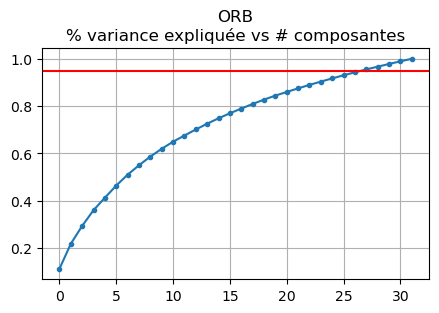

In [4]:
with hlp.Profile() as orb_features_pca_profile:
    orb_features_pca = features_pca(orb_features.train_features)

print("ORB Features PCA:", orb_features_pca_profile.round_duration(), "s")
print("ORB Features PCA valeurs propres:")
print(orb_features_pca["pca"].explained_variance_)

features_pca_analysis(orb_features_pca["pca"], "ORB", 0.95)

Le graphique précédant n'exhibe pas de "coude franc". Nous établisons donc un seuil à 95% ce qui permet de garder 26 composantes sur les 32 d'origine. Ce paramètre est intégré dans notre pipeline dans l'étape suivante via les fichiers de configuration.  

In [5]:
# ATTENTION: cette etape peut etre longue a la 1e execution
#            elle est sans feedback visuel, soyez patient
with hlp.Profile() as orb_bovw_profile:
    orb_bovw = vw.load_bovw(configs.orb_bovw, orb_features.train_features)

print("ORB BoVW loading:", orb_bovw_profile.round_duration(), "s")
print("ORB BoVW clusters:", orb_bovw.cluster_centers.shape)

ORB BoVW loading: 0.0 s
ORB BoVW clusters: (500, 26)


In [6]:
with hlp.Profile() as sift_features_pca_profile:
    sift_features_pca = features_pca(sift_features.train_features)

ORB Features PCA: 7.73 s
ORB Features PCA valeurs propres:
[11.63119871  9.49010062  7.88424028  5.62626378  5.4850498   4.75940524
  4.43607164  4.14595605  4.04722912  3.55061558  2.81722823  2.56037192
  2.50692452  2.33739838  2.29824669  2.20936932  1.97103099  1.86914875
  1.79687397  1.76519823  1.67053632  1.59252672  1.53873325  1.36196497
  1.30841836  1.24974267  1.20223366  1.14035549  1.12129869  0.99891027
  0.9740871   0.95339544  0.90427552  0.89546074  0.87531501  0.84712211
  0.84577949  0.81870251  0.79945642  0.79644409  0.74975871  0.69788843
  0.69273653  0.66984611  0.6571942   0.63593912  0.60617717  0.58823751
  0.56282121  0.53925823  0.51591009  0.50663094  0.49002343  0.47084705
  0.47005058  0.43719488  0.4182962   0.40361947  0.39765727  0.39526953
  0.38825703  0.3714466   0.36265165  0.35479141  0.35398138  0.34566124
  0.33824561  0.33407152  0.31462776  0.31291107  0.30461405  0.29714688
  0.29388441  0.29318525  0.2822817   0.26622975  0.25581966  0.2

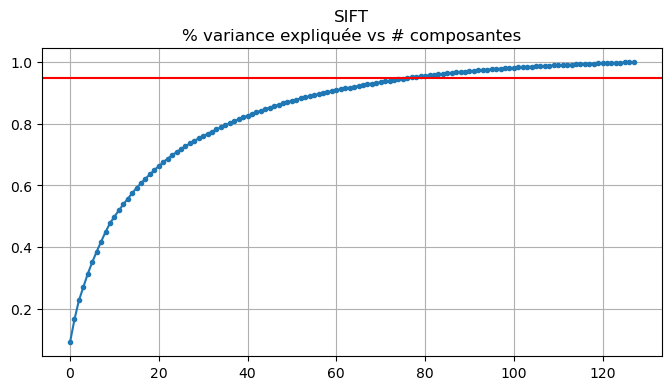

In [7]:
print("ORB Features PCA:", sift_features_pca_profile.round_duration(), "s")
print("ORB Features PCA valeurs propres:")
print(sift_features_pca["pca"].explained_variance_)

features_pca_analysis(sift_features_pca["pca"], "SIFT", 0.95, (8, 4))

De la même manière que précédement, nous établisons donc un seuil à 95% ce qui permet de garder 80 composantes sur les 128 d'origine. Ce paramètre est intégré dans notre pipeline dans l'étape suivante via les fichiers de configuration.

In [8]:
# ATTENTION: cette etape peut etre longue a la 1e execution
#            elle est sans feedback visuel, soyez patient
with hlp.Profile() as sift_bovw_profile:
    sift_bovw = vw.load_bovw(configs.sift_bovw, sift_features.train_features)

print("SIFT BoVW loading:", sift_bovw_profile.round_duration(), "s")
print("SIFT BoVW clusters:", sift_bovw.cluster_centers.shape)

SIFT BoVW loading: 0.0 s
SIFT BoVW clusters: (500, 80)
